In [1]:
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)
import pandas as pd
import glob
import os
import pypfopt as pyp
import quantstats as qs
import numpy as np
import matplotlib.pyplot as plt
import utils as u
%load_ext autoreload

In [179]:
hour_df_mid_usd = pd.read_csv('../cleaned_data/hour_data_mid_usd.csv', index_col='time_utc')
hour_df_mid_usd.index = pd.to_datetime(hour_df_mid_usd.index).tz_localize('UTC').tz_convert('America/New_York')
hour_df_usd_price = (1/hour_df_mid_usd).fillna(method='ffill')
hour_df_usd_returns = hour_df_usd_price.pct_change()
curr_list = ['USD.EUR.SPOT', 'USD.JPY.SPOT', 'USD.CAD.SPOT']
hour_df_usd_returns = hour_df_usd_returns[curr_list]
# drop the first hour after the hour break
hour_df_usd_returns = hour_df_usd_returns[~((hour_df_usd_returns.index.hour ==18) & (hour_df_usd_returns.index.hour == 1))].dropna()
hour_df_usd_price_tr = hour_df_usd_price.loc[:'2022-06-30']
hour_df_usd_returns_tr = hour_df_usd_returns.loc[:'2022-06-30']

In [180]:
minute_df_mid_usd = pd.read_csv('../cleaned_data/minute_data_mid_usd.csv', index_col='time_utc')
minute_df_mid_usd.index = pd.to_datetime(minute_df_mid_usd.index).tz_localize('UTC').tz_convert('America/New_York')
minute_df_usd_price = (1/minute_df_mid_usd).fillna(method='ffill')
minute_df_usd_returns = minute_df_usd_price.pct_change()
curr_list = ['USD.EUR.SPOT', 'USD.JPY.SPOT', 'USD.CAD.SPOT']
minute_df_usd_returns = minute_df_usd_returns[curr_list]
# drop the first minute after the hour break
minute_df_usd_returns = minute_df_usd_returns[~((minute_df_usd_returns.index.hour ==18) & (minute_df_usd_returns.index.minute == 1))].dropna()
minute_df_usd_price_tr = minute_df_usd_price.loc[:'2022-06-30']
minute_df_usd_returns_tr = minute_df_usd_returns.loc[:'2022-06-30']

In [181]:
df_dict = {}
returns_dict = {}
for p in range(0,24):
    if p!=17:
        df_dict[p] = minute_df_usd_price_tr[minute_df_usd_price_tr.index.hour ==p]
        returns_dict[p] = minute_df_usd_returns_tr[minute_df_usd_returns_tr.index.hour ==p]

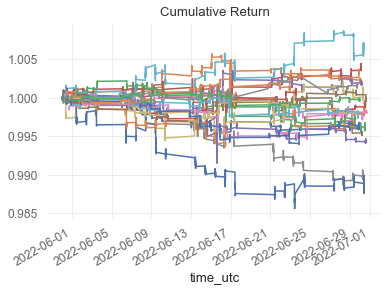

In [197]:
returns_static_dict = {}
cumul_returns_static_dict = {}
vol_static = []
port_static_dict ={}
s_date = '2022-05-30'
for x in df_dict.keys():
    port_m = u.portfolio.markowitz_rebalance(returns_dict[x],None,len(returns_dict[x][:s_date]),static_start_date=s_date,verbose=False,returns_data=True)
    port_static_dict[x] = port_m
    bt = u.backtest.portfolio_backtest(port_m,returns_dict[x], returns_data=True)
    cumul_returns_static_dict[x] =bt[0]
    vol_static.append(bt[1])
    returns_static_dict[x] =bt[2]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '18'),
  Text(18, 0, '19'),
  Text(19, 0, '20'),
  Text(20, 0, '21'),
  Text(21, 0, '22'),
  Text(22, 0, '23')])

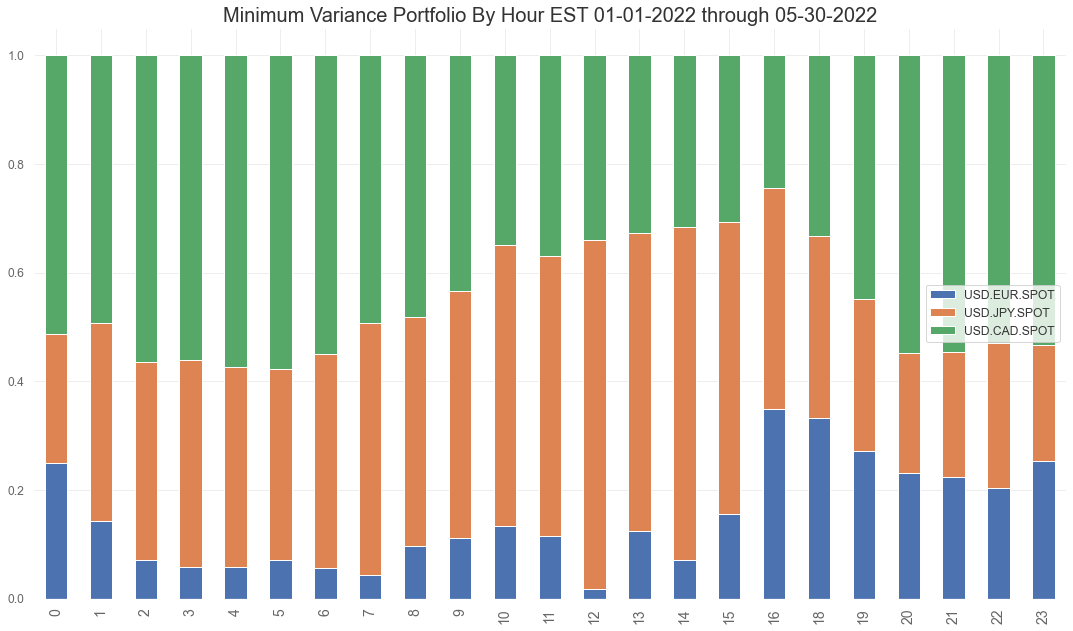

In [198]:
weight_df = pd.concat(port_static_dict, axis=0).droplevel(axis=0,level=0)
weight_df.index = weight_df.index.hour
ax = weight_df.plot.bar(stacked=True)
ax.legend(loc=5)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax.axes.set_title("Minimum Variance Portfolio By Hour EST 01-01-2022 through 05-30-2022", fontsize=20)
plt.xticks(fontsize=14)

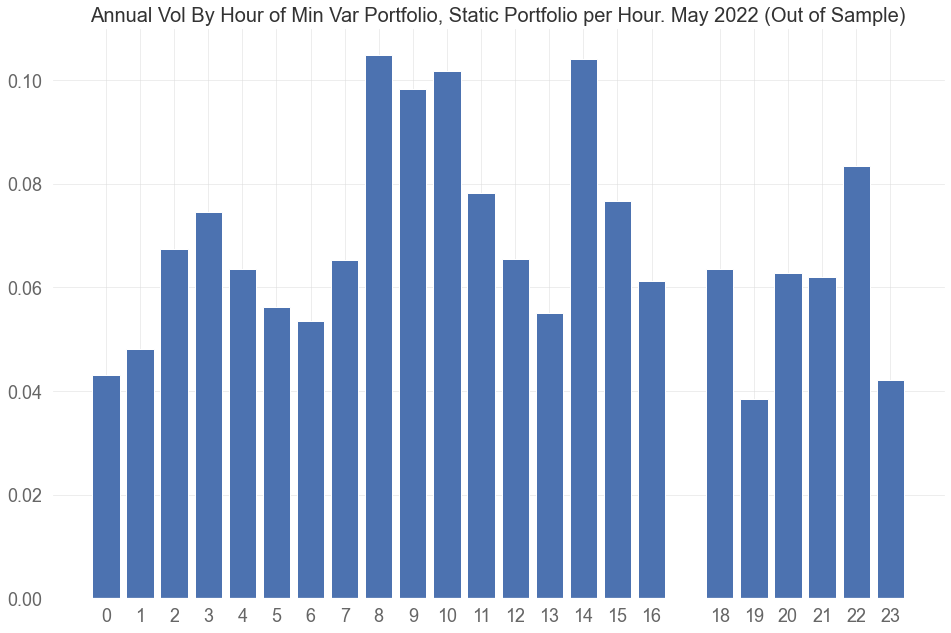

In [184]:
vol_static_ann= np.array(vol_static)*(60*23*252)**(1/2)
plt.bar(weight_df.index,vol_static_ann)
plt.title("Annual Vol By Hour of Min Var Portfolio, Static Portfolio per Hour. May 2022 (Out of Sample)", fontsize=20)
plt.xticks(weight_df.index,fontsize=18)
plt.yticks(fontsize=18)
fig = plt.gcf()
fig.set_size_inches(16, 10.5)


### Rolling 2-1-2022 thru 5-31-2022

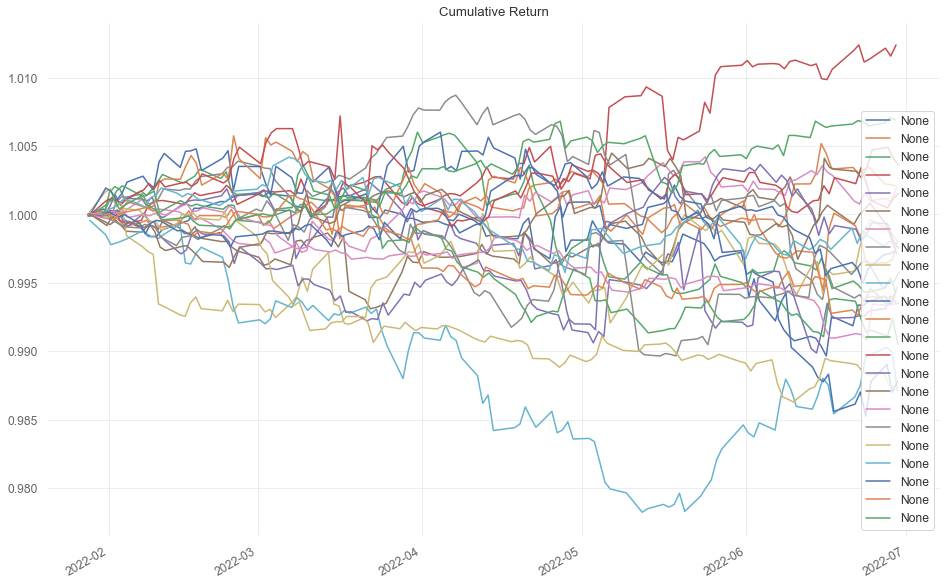

In [185]:
returns_rolling_dict = {}
cumul_returns_rolling_dict = {}
vol_rolling = []
port_rolling_dict ={}
for x in df_dict.keys():
    port_m = u.portfolio.markowitz_rebalance(returns_dict[x],60,60*10,static_start_date='2022-01-31',verbose=False,returns_data=True)
    port_rolling_dict[x] = port_m
    bt = u.backtest.portfolio_backtest(port_m,returns_dict[x], returns_data=True)
    cumul_returns_rolling_dict[x] =bt[0]
    vol_rolling.append(bt[1])
    returns_rolling_dict[x] =bt[2]
plt.legend()
fig = plt.gcf()
fig.set_size_inches(16, 10.5)

In [186]:
from copy import deepcopy

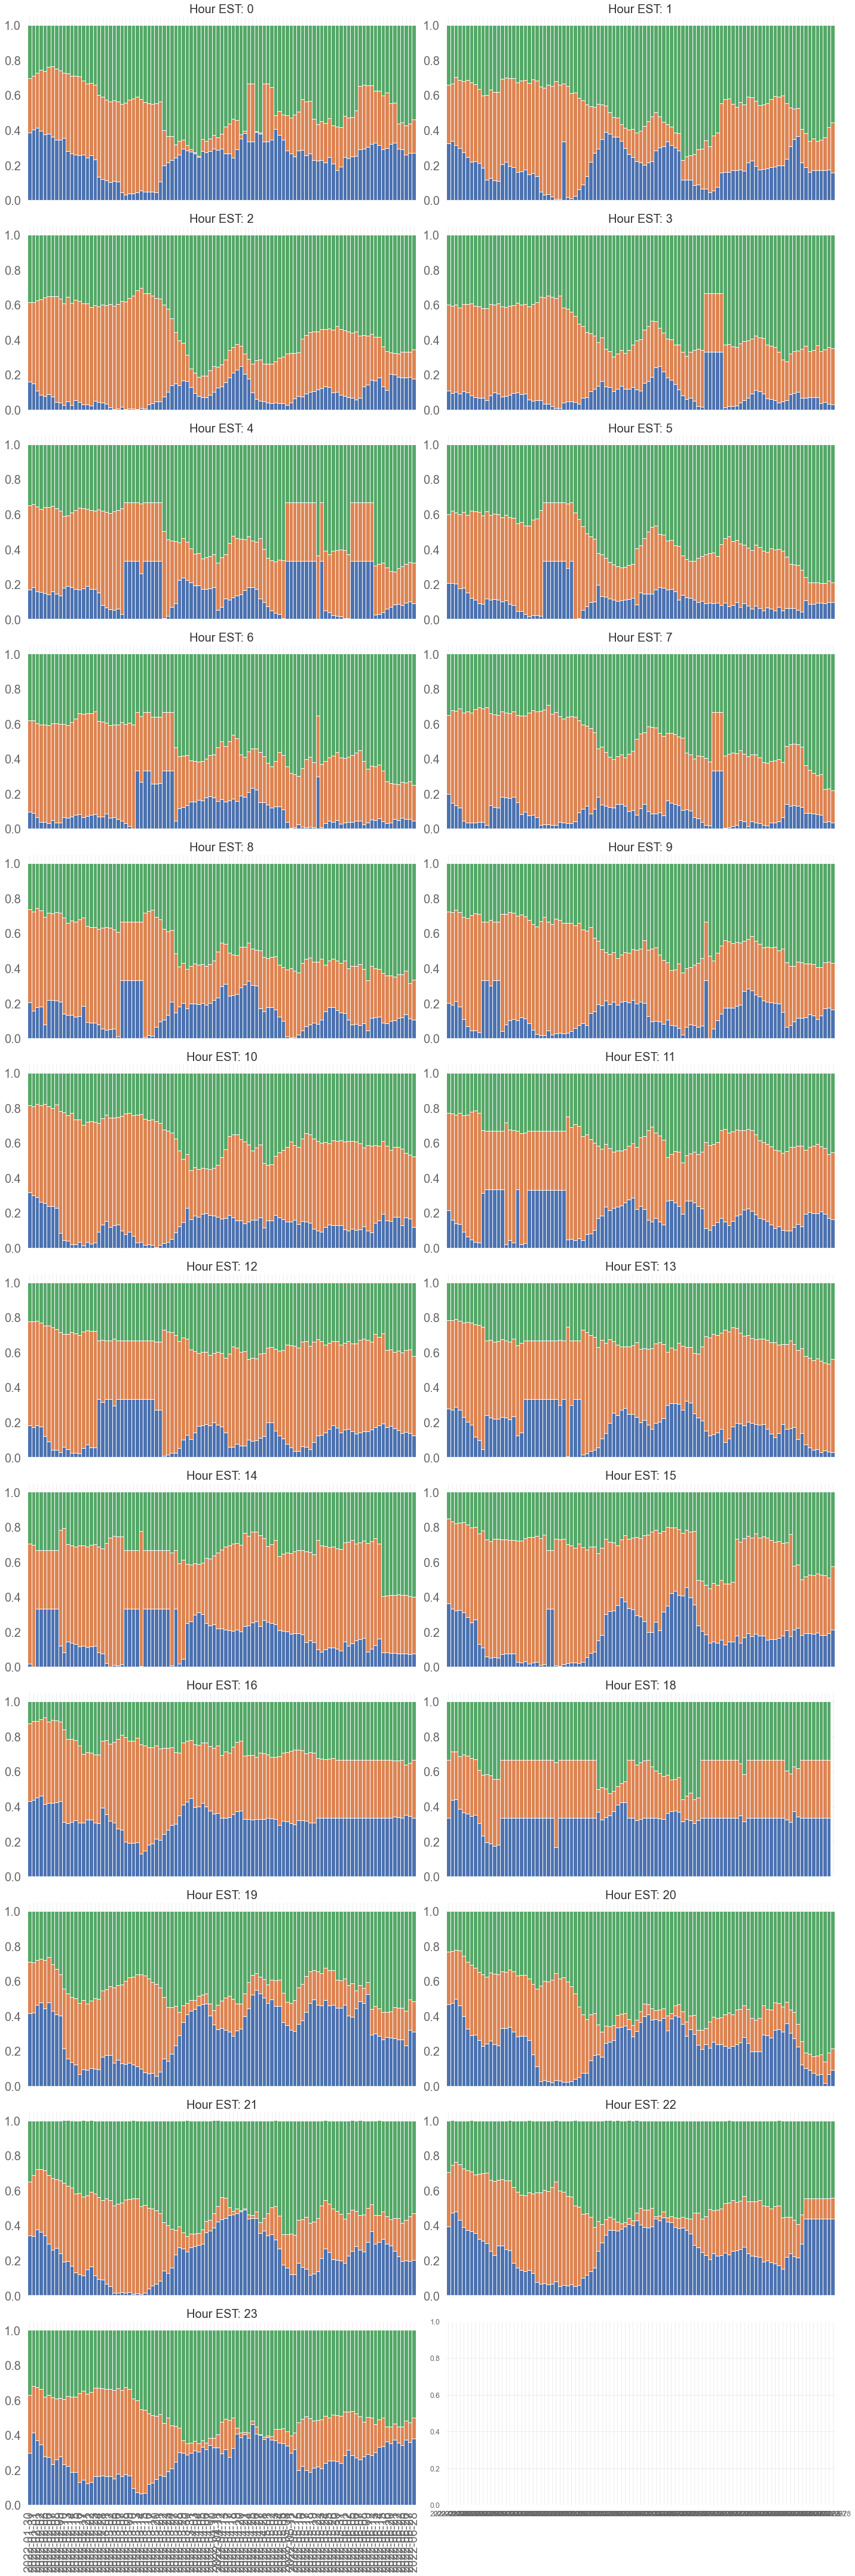

In [187]:
port_rolling_dict_g = deepcopy(port_rolling_dict)
fig, axarr = plt.subplots(int(len(port_rolling_dict_g.keys())/2+1),2, figsize=(20,60), sharex=True)
i=0
for x in port_rolling_dict.keys():
    port_rolling_dict_g[x].index = port_rolling_dict_g[x].index.date
    port_rolling_dict_g[x].plot.bar(ax=axarr[int(i/2)][i%2],stacked=True, legend=False, width=1.0,fontsize=20)
    #axarr[int(i/2)][i%2].set_xticks(port_rolling_dict_g[x].index, rotation=45)
    axarr[int(i/2)][i%2].set_title("Hour EST: " + str(x), fontsize=20)
    i+=1
fig.tight_layout()

([<matplotlib.axis.XTick at 0x12fa479bc10>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

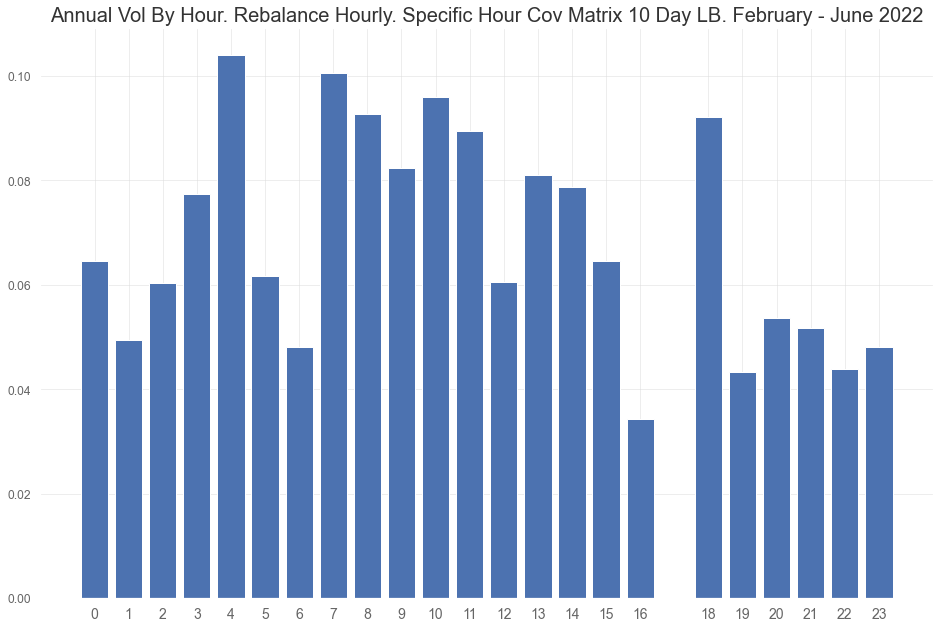

In [188]:
vol_rolling_ann= np.array(vol_rolling)*(23*252)**(1/2)
plt.bar(weight_df.index,vol_rolling_ann)
plt.title("Annual Vol By Hour. Rebalance Hourly. Specific Hour Cov Matrix 10 Day LB. February - June 2022", fontsize=20)
fig = plt.gcf()
fig.set_size_inches(16, 10.5)
plt.xticks(weight_df.index,fontsize=14)

### Volatility by hour based on only daily

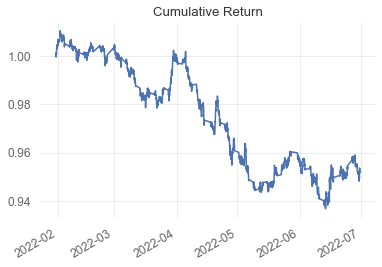

In [203]:
s_date = '2022-1-31'
port_daily = u.portfolio.markowitz_rebalance(minute_df_usd_returns_tr,60,60*10*23,static_start_date=s_date,verbose=False,returns_data=True)
bt_daily = u.backtest.portfolio_backtest(port_daily,minute_df_usd_returns_tr, returns_data=True)

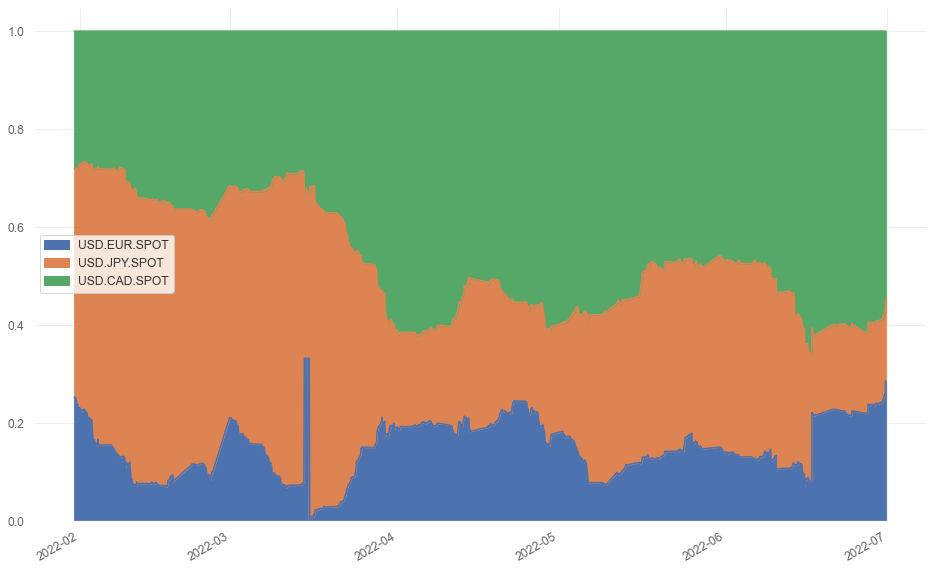

In [190]:
port_daily.plot.area()
fig = plt.gcf()
fig.set_size_inches(16, 10.5)

In [191]:
returns_daily_dict = {}
vol_daily_list = []
for p in range(0,24):
    if p!=17:
        returns_daily_dict[p] = bt_daily[2][bt_daily[2].index.hour ==p]
        vol_daily_list.append(returns_daily_dict[p].std()*(23*252)**(1/2))

([<matplotlib.axis.XTick at 0x12fa4960700>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

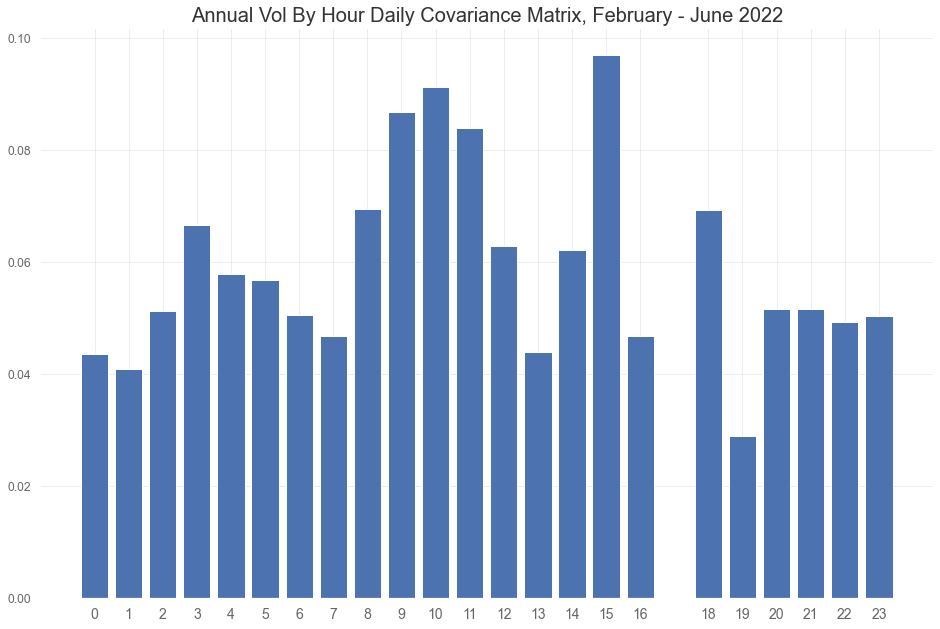

In [192]:
plt.bar(weight_df.index,vol_daily_list)
plt.title("Annual Vol By Hour Daily Covariance Matrix, February - June 2022", fontsize=20)
fig = plt.gcf()
fig.set_size_inches(16, 10.5)
plt.xticks(weight_df.index,fontsize=14)

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

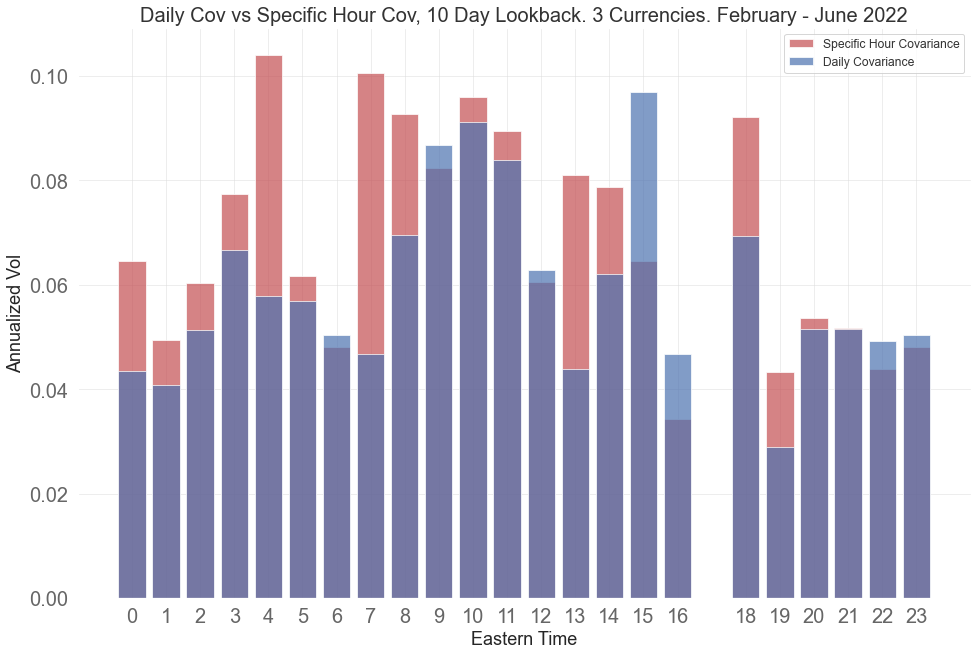

In [193]:
plt.bar(weight_df.index,vol_rolling_ann, alpha=.7, color='r')
plt.bar(weight_df.index,vol_daily_list, alpha=.7)
plt.legend(['Specific Hour Covariance','Daily Covariance',])
plt.title("Daily Cov vs Specific Hour Cov, 10 Day Lookback. 3 Currencies. February - June 2022", fontsize=20)
plt.xlabel('Eastern Time', fontsize=18)
plt.ylabel('Annualized Vol', fontsize=18)
fig = plt.gcf()
fig.set_size_inches(16, 10.5)
plt.xticks(weight_df.index,fontsize=20)
plt.yticks(fontsize=20)

In [199]:
cov_by_hour_returns = pd.concat(returns_rolling_dict).droplevel(level=0)
cov_by_hour_returns = cov_by_hour_returns.sort_index().dropna()
hour_equal = hour_df_usd_returns_tr.loc['02-01-2022':].sum(axis=1)/3

(array([19024., 19052., 19083., 19113., 19144., 19174.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

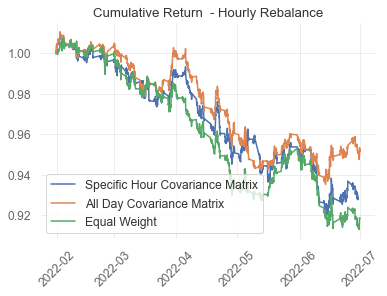

In [200]:
plt.plot(1+cov_by_hour_returns.cumsum())
plt.plot(1+bt_daily[2].cumsum())
plt.plot(1+hour_equal.cumsum())
plt.legend(['Specific Hour Covariance Matrix', 'All Day Covariance Matrix', 'Equal Weight'])
plt.plot()
plt.title('Cumulative Return  - Hourly Rebalance')
plt.xticks(rotation=45)

(array([19024., 19052., 19083., 19113., 19144., 19174.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

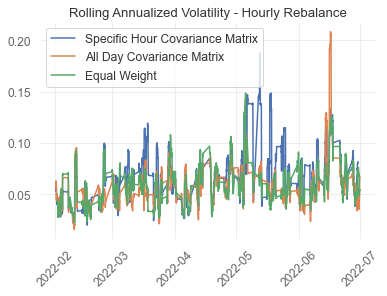

In [201]:
plt.plot(cov_by_hour_returns.rolling(21).std()*(23*252)**(1/2))
plt.plot(bt_daily[2].rolling(21).std()*(23*252)**(1/2))
plt.plot(hour_equal.rolling(21).std()*(23*252)**(1/2))
plt.legend(['Specific Hour Covariance Matrix', 'All Day Covariance Matrix', 'Equal Weight'])
plt.plot()
plt.title('Rolling Annualized Volatility - Hourly Rebalance')
plt.xticks(rotation=45)